## Centroid measurement
Let us start with the usual imports, and then we read one image.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle

from astropy.io import fits
science_list = np.genfromtxt('/home/alcadis/Desktop/lab2/group13_WASP-12_20230113/science/science.list', dtype=str)
science_test_list = science_list[:10]
science_frame_name = '/home/alcadis/Desktop/lab2/group13_WASP-12_20230113/correct/' + science_test_list[-1][:-5] + '_corr.p'
science_corrected = pickle.load(open(science_frame_name, 'rb'))

## Identification of the target and reference stars
Open a scientific frame and display it in order to identify the target star (the one with the transiting planet) and the reference stars (used to do differential photometry). You will need to use SIMBAD for a correct identification.
You can play with the vmin and vmax value to highlight fainter stars.

vmin:  692.3    vmax: 94792.0


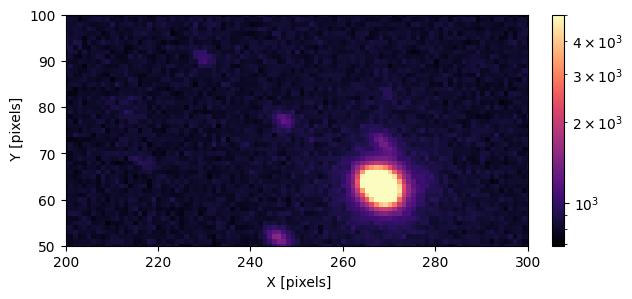

In [2]:
vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}    vmax: {1:.1f}'.format(vmin, vmax))
vmax = 5000

fig, ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)
plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.xlim([200, 300])
plt.ylim([50, 100])
plt.show()

You can get an approximate location by rolling the mouse over the star and taking note of the numbers displayed in the lower part of the frame. These are the values that I got:

In [3]:
x_target = 267
y_target = 63
x_reference_01 = 87
y_reference_01 = 60

You don't need to be extremely precise in defining the centers, at this stage. We can get a better refinement by drawing a circle around each star. To speed up the process, I wrapped the plotting routines inside a function:

In [4]:
def make_circle_around_star(x_pos, y_pos, label='', color='w'):
    n, radii = 50, [9, 15]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=0.75, label=label)

Thanks to the function, you can draw as many circles as you want by simply adding one line of code. Below, I ran the script several times, changing slightly the position of the circles every time, until they were well centered around the star (Note: integer values are fine)

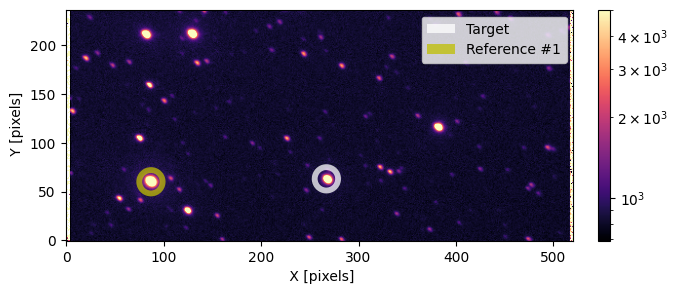

In [5]:
fig, ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)

make_circle_around_star(x_target, y_target, label='Target', color='w')
make_circle_around_star(x_reference_01, y_reference_01, label='Reference #1', color='y')
plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
ax.legend()
plt.show()

## Photocenter determination of a star
Technically speaking, the photocentre is the centre of light production of a dispersed source. It can also be defined as the marked peak in intensity at the centre of an Airy disk, or the point of maximum intensity of the combined light from an unresolved binary star. In our analysis, we will use the term photocentre to identify the average position of the target on the sensor, knowing that the light distribution may have an irregular shape if the telescope has been defocused on purpose, as it is customary when collecting light curves for transit detection-

Remember that we are working only with the first ten science frames to test our code before running it unchecked over hundreds or thousands of images.

During the lecture, we made a 3D plot of our target star to have a clearer idea of the possible radius from the star's centre at which the star flux is negligible. After creating two 1D arrays with the values of our frame's  
x
  and  
y
  coordinates, we employed the numpy.meshgrid function to build two 2D arrays X and Y. Each array has the shape of our scientific frame, and each array contains the coordinate  
x
  (in X) and  
y
  (in Y) of the corresponding pixel.

In [6]:
ylen, xlen  = np.shape(science_corrected)
print('Shape of our science frame: {0:d} x {1:d}'.format(xlen, ylen))
X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

i = 23
j = 73
print(X[i, j])
print(Y[i, j])

Shape of our science frame: 521 x 237
73
23


Suppose we display the 3D plot of the full image. In that case, we will get quite a disappointing and little informative output, as the automatic rescaling of the vertical axis  
z
  (in our case, corresponding to the flux recorded in every pixel) will be affected by the nasty values in the overscan region.

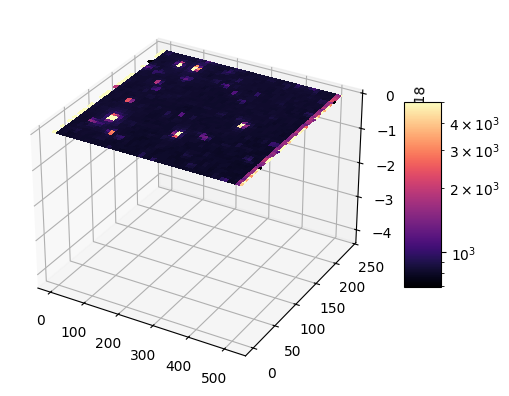

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Let's make the plot again, with a few improvements:

We centre the 3d plot around the estimated coordinates of our target x_target and y_target;
we limit our plot within a radius of 15 pixels around the centre of the target, using the radius_plot parameter:
we change the vmax value to 4000 to display more details of the flux distribution over the pixels.
I used additional keywords for the colorbar to make it smaller and thinner. Try different combinations of those keywords to check how they affect the appearance of the colorbar-
Note that the values for radius_plot and vmax listed above work well in my case, but you may need to change them for your target.

/tmp/ipykernel_7398/2176124984.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 640x480 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(surf, shrink=0.5, aspect=5, ticks=[10, 100, 1000, 10000, 100000])


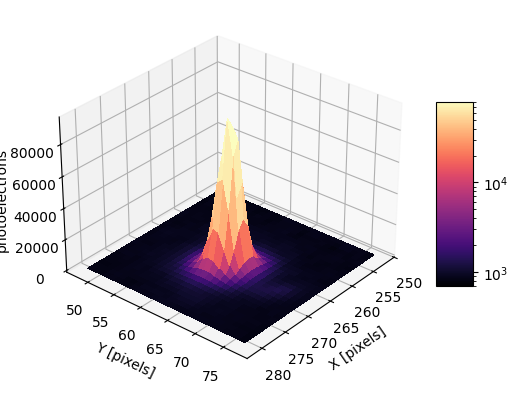

In [8]:
radius_plot = 15
fix, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X[y_target - radius_plot:y_target+radius_plot, x_target - radius_plot:x_target + radius_plot],
                       Y[y_target - radius_plot:y_target+radius_plot, x_target - radius_plot:x_target + radius_plot],
                       science_corrected[y_target - radius_plot:y_target+radius_plot, x_target - radius_plot:x_target + radius_plot],
                       cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax+75000), linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5, ticks=[10, 100, 1000, 10000, 100000])

# Force rotation of the plot to get the numbers on the left side
# You can get the azimuth and elevation of the observer on the lower part of the plot
# when rotating the image
ax.azim = 40 # value in degree
ax.elev = 30 # value in degree
ax.set_xlabel('X [pixels]')
ax.set_ylabel('Y [pixels]')
ax.set_zlabel('photoelectrons', rotation=90)
# Fix the orientation fo the Z label
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
plt.show()

The shape of my target star is quite regular, but this is just a coincidence. Defocusing the telescope is indeed a common technique to avoid saturation when performing time-series photometry of bright stars. Without defocusing, you may reach saturation in a time shorter than the shortest exposure time the camera's shutter allows. The side effect of defocusing is a decrease in the image quality of the telescope, which, however, is not relevant when performing aperture photometry. However, it would be highly detrimental in PSF photometry, where you try to fit the shape of the star on the detector with an analytical or empirical function. For example, check this document on ESO website and references therein.

## Advantages of using numpy.meshgrid

Computing two 2D arrays containing one of the two coordinates of each pixel may appear as an unnecessary complication. We can convince ourselves that the effort is worthy with a simple example that is valuable for our science case.

Suppose we want to compute the distance of each pixel from the photocentre of our star. We need this information to select the pixels inside the aperture to measure the star's flux and select the pixels within the annulus to measure the sky background. We compare two algorithms, with only one using numpy.meshgrid, and determine which performs better.

First of all, we have to define a reliable way to measure the performances of our algorithms. We will use the Python standard library time for this task. Specifically, the function time.time() reports the number of seconds passed since January 1, 1970, 00:00:00 (UTC). This information alone is not very useful, but if we store the times before and after running our algorithm, their difference will tell us the time spent by the algorithm in performing the computation.

In [9]:
import time

t0 = time.time()

print('Seconds passed since January 1, 1970, 00:00:00 (UTC): {0:.4f}'.format(t0))

t1 = time.time()

delta_time = t1 - t0
print('Time spent to print the previous information: {0:f} seconds'.format(delta_time))

Seconds passed since January 1, 1970, 00:00:00 (UTC): 1732100055.1132
Time spent to print the previous information: 0.000064 seconds


Let's move to the definition of the first algorithm. The first approach would be to iterate over each pixel and compute its distance from the star. Specifically, for each value of the  
x
  coordinate, we go through all the values of the  
y
  coordinate and store the result of the computation in an array with the same shape as our reference frame.

In [10]:
t0 = time.time()

rr_method01 = np.zeros_like(science_corrected)
for yi in range(0,np.shape(science_corrected)[0]):
    for xi in range (0, np.shape(science_corrected)[1]):
        rr_method01[yi, xi] =  np.sqrt((xi-x_target)**2 + (yi-y_target)**2)

t1 = time.time()

total_method01 = t1-t0
print('Time required by the first method: {0:f} seconds'.format(total_method01))

Time required by the first method: 0.200503 seconds


In the second algorithm, we again compute the X and Y 2D arrays through meshgrid. As these two arrays already contain the  
x
  and  
y
  coordinates of each pixel, and the two arrays have the same shape as our science frame, the computation of the distance from the target star is immediate.

Additionally, we divide our benchmarking into two steps: as all the images have the same shape, the step involving meshgrid will be performed only once at the beginning of our analysis, so its computation time will contribute only once to the total time of execution, regardless the number of images. The step where the distance from the target is computed will constitute the major contributor to the time of execution of our code.

In [11]:
t0 = time.time()

X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

t1 = time.time()

rr_method02 = np.sqrt((X-x_target)**2 + (Y-y_target)**2)

t2 = time.time()

prepare_method02 = t1-t0
total_method02 = t2-t1
print('Time required to set up the second algorithm: {0:f} seconds'.format(prepare_method02))
print('Time required by second algorithm:            {0:f} seconds'.format(total_method02))

Time required to set up the second algorithm: 0.001107 seconds
Time required by second algorithm:            0.000988 seconds


In [12]:
print('Algorithm using meshgrid is {0:.0f} times faster'.format(total_method01/total_method02))

Algorithm using meshgrid is 203 times faster


## Centroid algorithm

There are many ways to determine the centre of a distribution. We could use partial derivatives, fit for a function representative of our distribution, employ an empirical mode based on a subsample of observations, or use a machine learning approach... As for any problem, we can select the best solution if we think about our goals and requirements. We need:

1) a fast algorithm, as it has to run several times on hundreds of images
2) a robust algorithm, i.e., it reaches convergences regardless of the initial conditions and perturbations of the initial conditions)
3) a simple algorithm that can work without any prior knowledge of the Point Spread Function of the instrument, as the telescope defocusing will change night by night.
4) 
For our purposes, we are going to use the weighted centroid. We weigh the coordinates of each pixel xi, yi according to the flux collected by that pixel  Fi. We compute the average over the pixel within a distance inner_radius from the centre of the target. Following the definition of the weighted average, the average of each coordinate is equal to the weighted sums ∑xiFi and  ∑yiFi divided by the sum of the weights, i.e., the total flux within the inner radius F = ∑Fi.

The inner radius must be large enough to include all the flux coming from the star, and some sky background as well. Don't be greedy with this value! Its value in pixel is stored in the inner_radius variable. We will come back later to the meaning of this parameter.

You have already seen the weighted average in the past, most likely using the inverse of the square of the errors as weights. Here, you are using the same tool, with just the flux as weights.

In [13]:
#Centroid algorithm

# Value for the inner radius
inner_radius = 14

# Computing again the meshgrid arrays 
ylen, xlen = np.shape(science_corrected)
X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

# 2D array with the distance of each pixel from the target star 
target_distance = np.sqrt((X-x_target)**2 + (Y-y_target)**2)

# Selection of the pixels within the inner radius
annulus_sel = (target_distance < inner_radius)

# Weighted sum of coordinates
weighted_X = np.sum(science_corrected[annulus_sel]*X[annulus_sel])
weighted_Y = np.sum(science_corrected[annulus_sel]*Y[annulus_sel])

# Sum of the weights
total_flux = np.sum(science_corrected[annulus_sel])

# Refined determination of coordinates
x_target_refined = weighted_X/total_flux
y_target_refined = weighted_Y/total_flux

print('Initial coordinates  x: {0:5.2f}   y: {1:5.2f}'.format(x_target, y_target))
print('Refined coordinates  x: {0:5.2f}   y: {1:5.2f}'.format(x_target_refined, y_target_refined))

Initial coordinates  x: 267.00   y: 63.00
Refined coordinates  x: 267.62   y: 63.06


Note: Ensure the inner annulus fully includes the star's flux, with some background around it. Below, you can find an example where the vmax value has been set to twice the background level to highlight the boundaries of the star. An example of a good inner radius (white line) and a bad inner radius (yellow line) are shown.

vmin:  692.3    vmax: 94792.0


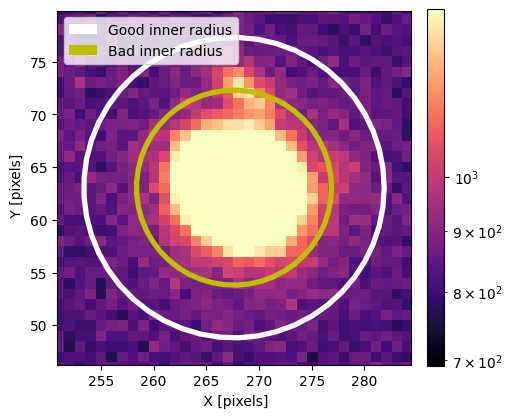

In [14]:
def make_circle_around_star(x_pos, y_pos, radius, thickness=0.5, label='', color='w', alpha=1.):
    from matplotlib.patches import Circle

    n, radii = 50, [radius, radius+thickness]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=alpha, label=label)


from matplotlib import colors 

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}    vmax: {1:.1f}'.format(vmin, vmax))
vmax = 2*vmin

fig, ax = plt.subplots(1, figsize=(5,5))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)

# Cut the plot around the target star, with some margin with respect to the inner radius
plt.xlim(x_target_refined-inner_radius*1.2, x_target_refined+inner_radius*1.2)
plt.ylim(y_target_refined-inner_radius*1.2, y_target_refined+inner_radius*1.2)

make_circle_around_star(x_target_refined, y_target_refined, inner_radius, label='Good inner radius')
make_circle_around_star(x_target_refined, y_target_refined, 9, color='y', label='Bad inner radius')

plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.legend(loc='upper left')
plt.show()

You may have noticed that our algorithm for a precise and robust determination of the photocenter requires an initial guess, also called starting point. This situation is not uncommon: the choice of a starting point is considered the major pitfall of Markov Chain Monte Carlo (MCMC) algorithms. For complex analysis, you may need a specific algorithm to identify your starting point. In this case, the identification is pretty straightforward, as you only need to find the approximate centre of a big circle using your mouse. However, we may wonder how much a specific choice of the starting point may affect the output of our algorithm (another problem in common with MCMC). Suppose our starting point is quite far from the real (unknown) value but still in a reasonable range (i.e., the starting point is not in an empty region of the sky). In that case, it is reasonable to think that the centroid algorithm will bring us closer to the real value, thus providing a better starting point for another iteration of the algorithm. In other words, we can check how many iterations our algorithms need to determine the centroid with a given precision given an approximate starting point.

To do so, we include our algorithm in a cycle where the new photocenter measurement is used as a starting point for the next iteration. We stop the cycle when either the maximum number of iterations is reached, or the variation in the coordinates between two consecutive iterations (percent variance) is smaller than a given threshold ( e.g., 0.1%)

In [16]:
#Centroid algorithm

# Initial coordinates of the target
x_target_initial = x_target
y_target_initial = y_target

maximum_number_of_iterations = 30

# Computing again the meshgrid arrays 
#ylen, xlen = np.shape(science_corrected)
#X_axis = np.arange(0, xlen, 1)
#Y_axis = np.arange(0, ylen, 1)
#X, Y = np.meshgrid(X_axis, Y_axis)

print('Initial coordinates  x: {0:5.2f}   y: {1:5.2f}'.format(x_target_initial, y_target_initial))

for i_iter in range(0, maximum_number_of_iterations):

    if i_iter == 0:
        # first iteration
        x_target_previous = x_target_initial
        y_target_previous = y_target_initial
    else:
        # using the previous result as starting point
        x_target_previous = x_target_refined
        y_target_previous = y_target_refined

    # 2D array with the distance of each pixel from the target star 
    target_distance = np.sqrt((X-x_target_previous)**2 + (Y-y_target_previous)**2)

    # Selection of the pixels within the inner radius
    annulus_sel = (target_distance < inner_radius)
    
    # Weighted sum of coordinates
    weighted_X = np.sum(science_corrected[annulus_sel]*X[annulus_sel])
    weighted_Y = np.sum(science_corrected[annulus_sel]*Y[annulus_sel])
    
    # Sum of the weights
    total_flux = np.sum(science_corrected[annulus_sel])

    # Refined determination of coordinates
    x_target_refined = weighted_X/total_flux
    y_target_refined = weighted_Y/total_flux
    
    percent_variance_x = (x_target_refined-x_target_previous)/(x_target_previous) * 100.
    percent_variance_y = (y_target_refined-y_target_previous)/(y_target_previous) * 100.
    
    print('    Iteration {0:3d}   x: {1:.3f} ({2:.2f}%)  y: {3:.3f} ({4:.2f}%)'.format(i_iter,
                                                                                   x_target_refined, 
                                                                                   percent_variance_x,
                                                                                   y_target_refined,
                                                                                   percent_variance_y))
          
    # exit condition: both percent variance are smaller than 0.1%
    if np.abs(percent_variance_x)<0.1 and  np.abs(percent_variance_y)<0.1:
          break

print('Refined coordinates  x: {0:5.2f}   y: {1:5.2f}'.format(x_target_refined, y_target_refined))

Initial coordinates  x: 267.00   y: 63.00
    Iteration   0   x: 267.623 (0.23%)  y: 63.060 (0.10%)
    Iteration   1   x: 267.795 (0.06%)  y: 63.081 (0.03%)
Refined coordinates  x: 267.80   y: 63.08


vmin:  692.3    vmax: 94792.0


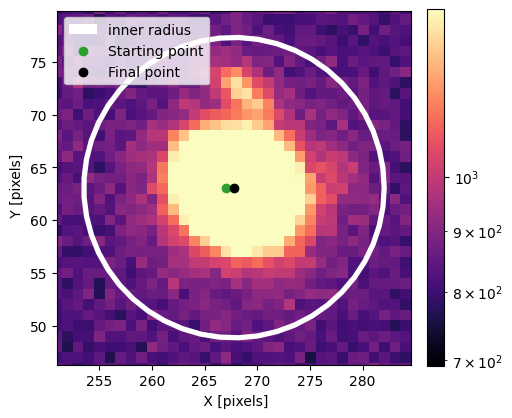

In [17]:
vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}    vmax: {1:.1f}'.format(vmin, vmax))
vmax = 2*vmin

fig, ax = plt.subplots(1, figsize=(5,5))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)

# Cut the plot around the target star, with some margin with respect to the inner radius
plt.xlim(x_target_refined-inner_radius*1.2, x_target_refined+inner_radius*1.2)
plt.ylim(y_target_refined-inner_radius*1.2, y_target_refined+inner_radius*1.2)

make_circle_around_star(x_target_refined, y_target_refined, inner_radius, label='inner radius')

ax.scatter(x_target_initial, y_target_initial, c='C2', label='Starting point')
ax.scatter(x_target_refined, y_target_refined, c='k', label='Final point')

plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.legend(loc='upper left')
plt.show()

Even in a case or a wildly wrong guess, our calgorithm converges to the correct position in just a few steps.

## Extra: measuring the Full Width Half Maximum of our centroid

We want to determine how large is our star, not just the position of the photocenter Knowing the scale of a pixel, we can convert this information onto the measured seeing.

Fpor more accurtate measurements, we should remove the sky background first. Except for this step, the algorithm would be identical

In [18]:
# flux within the annulus 
# 2D array with the distance of each pixel from the target star 
target_distance = np.sqrt((X-x_target_refined)**2 + (Y-y_target_refined)**2)

# Selection of the pixels within the inner radius
annulus_sel = (target_distance < inner_radius)

# We compute the sum of the total flux within the inner radius.
total_flux = np.nansum(science_corrected*annulus_sel) 

# We compute the sum of the flux along each axis, within the inner radius.
flux_x = np.nansum(science_corrected*annulus_sel, axis=0) 
flux_y = np.nansum(science_corrected*annulus_sel, axis=1) 

# We use the nansum function to avoid problems with the overscan region

/tmp/ipykernel_7398/2369449268.py:9: RuntimeWarning: invalid value encountered in multiply
  total_flux = np.nansum(science_corrected*annulus_sel)
/tmp/ipykernel_7398/2369449268.py:12: RuntimeWarning: invalid value encountered in multiply
  flux_x = np.nansum(science_corrected*annulus_sel, axis=0)
/tmp/ipykernel_7398/2369449268.py:13: RuntimeWarning: invalid value encountered in multiply
  flux_y = np.nansum(science_corrected*annulus_sel, axis=1)


In [19]:
# we compute the cumulative sum along each axis, normalized to the total flux
cumulative_sum_x = np.cumsum(flux_x)/total_flux
cumulative_sum_y = np.cumsum(flux_y)/total_flux

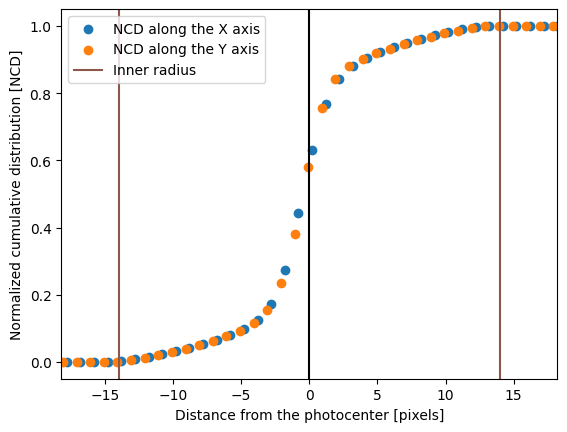

In [20]:
#Differences in the cumulative distribution will highlight asymmetries in the star's shape

plt.figure()
plt.scatter(X_axis-x_target_refined,cumulative_sum_x, label='NCD along the X axis')
plt.scatter(Y_axis-y_target_refined,cumulative_sum_y, label='NCD along the Y axis')
plt.axvline(0, c='k')

plt.xlim(-inner_radius*1.3, inner_radius*1.3)

plt.axvline(inner_radius, c='C5', label='Inner radius') 
plt.axvline(-inner_radius, c='C5')
plt.xlabel('Distance from the photocenter [pixels]')
plt.ylabel('Normalized cumulative distribution [NCD]')
plt.legend()

plt.show()

In [21]:
def determine_FWHM_axis(reference_axis, normalized_cumulative_distribution):
    
    # Find the closest point to NCD= 0.15865 (-1 sigma)
    NCD_index_left = np.argmin(np.abs(normalized_cumulative_distribution-0.15865))
    
    # Find the closest point to NCD= 0.84135 (+1 sigma)
    NCD_index_right = np.argmin(np.abs(normalized_cumulative_distribution-0.84135))

    # We model the NCD around the -1sgima value with a polynomial curve. 
    # The independet variable is actually the normalized cumulative distribution, 
    # the depedent variable is the pixel position
    p_fitted = np.polynomial.Polynomial.fit(normalized_cumulative_distribution[NCD_index_left-1: NCD_index_left+2],
                                            reference_axis[NCD_index_left-1: NCD_index_left+2],
                                            deg=2)

    # We get a more precise estimate of the pixel value corresponding to the -1sigma position
    pixel_left = p_fitted(0.15865)

    # We repeat the step for the 1sigma value
    p_fitted = np.polynomial.Polynomial.fit(normalized_cumulative_distribution[NCD_index_right-1: NCD_index_right+2],
                                            reference_axis[NCD_index_right-1: NCD_index_right+2],
                                            deg=2)
    pixel_right = p_fitted(0.84135)

    print(pixel_left, pixel_right)
    
    FWHM_factor = 2 * np.sqrt(2 * np.log(2)) # = 2.35482
    FWHM = (pixel_right-pixel_left)/2. * FWHM_factor

    return FWHM

In [22]:
FWHM_x = determine_FWHM_axis(X_axis, cumulative_sum_x)
FWHM_y = determine_FWHM_axis(Y_axis, cumulative_sum_y)
print('FWHM along the X axis: {0:.2f}'.format(FWHM_x)) 
print('FWHM along the X axis: {0:.2f}'.format(FWHM_x)) 

264.76682795137884 269.9981616177467
60.07208106577969 64.99537448350294
FWHM along the X axis: 6.16
FWHM along the X axis: 6.16


In [23]:
# From the fits header of the first image:
# CCDSCALE=                 0.25 / [arcsec/px] unbinned CCD camera scale
#BINX    =                    4 / Horizontal Binning factor used
#BINY    =                    4 / Vertical Binning factor used

print('Seeing along the X axis (after defocusing): {0:.2f}'.format(FWHM_x* 4*0.25)) 
print('Seeing along the Y axis (after defocusing): {0:.2f}'.format(FWHM_y* 4*0.25)) 

Seeing along the X axis (after defocusing): 6.16
Seeing along the Y axis (after defocusing): 5.80
